In [46]:
import pandas as pd
import numpy as np

(1797, 64)


<Figure size 432x288 with 0 Axes>

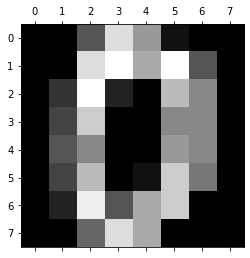

In [47]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
import matplotlib.pyplot as plt
plt.gray()
plt.matshow(digits.images[0])
plt.show()

In [48]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X[0,:]

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

In [49]:
from sklearn.model_selection import train_test_split
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
# преобразование ответов в вектора из 10 компонент
import numpy as np
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

y_train_vect = convert_y_to_vect(y_train)
y_test_vect = convert_y_to_vect(y_test)
y_train[0], y_train_vect[0]

(2, array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]))

In [51]:
class MyNeuroNet:
    
    def __init__(self, nn_structure: list, act_funct = 'sygmoid', alpha = 0.25, iter_num = 3000):
            self.layers = len(nn_structure)
            self.nn_structure = nn_structure
            self.act_funct = act_funct
            self.alpha = alpha
            self.iter_num = iter_num
    
    def f(self,x):
        import numpy as np
        if self.act_funct == 'sygmoid':
            return 1 / (1 + np.exp(-x))
        if self.act_funct == 'tanh':
            return (np.exp(x)-np.exp(-x)) / (np.exp(x) + np.exp(-x))
    def f_deriv(self,x):
        import numpy as np
        if self.act_funct == 'sygmoid':
            return self.f(x) * (1 - self.f(x))
        if self.act_funct == 'tanh':
            return 1-(self.f(x))**2

    def setup_and_init_weights(self):
        import numpy.random as r
        self.W = {}
        self.b = {}
        for l in range(1, len(self.nn_structure)):
            self.W[l] = r.random_sample((self.nn_structure[l], self.nn_structure[l-1]))
            self.b[l] = r.random_sample((self.nn_structure[l],))
        return self.W, self.b
    
    def init_cum_values(self):
        import numpy as np
        self.cum_W = {}
        self.cum_b = {}
        for l in range(1, len(self.nn_structure)):
            self.cum_W[l] = np.zeros((self.nn_structure[l], self.nn_structure[l-1]))
            self.cum_b[l] = np.zeros((self.nn_structure[l],))
        return self.cum_W, self.cum_b
    
    def outter_delta(self, y, h_out, z_out):
        return -(y-h_out) * self.f_deriv(z_out)

    def hidden_delta(self, delta_plus_1, w_l, z_l):
        return np.dot(delta_plus_1, w_l) * self.f_deriv(z_l)
    
    def forward_way(self, x, w, b):
        import numpy as np
        h = {0: x}
        z = {}
        for i in range(1, len(self.nn_structure)):
            if i == 1:
                res = x
            z[i] = np.dot(res, w[i].transpose()) + b[i].transpose()
            res = self.f(np.dot(res, w[i].transpose()) + b[i].transpose())
            h[i] = res

        return h, z

    def back_way(self, y, w, b, h, z):
        import numpy as np
        for i in range(1, len(self.nn_structure)):
                j = len(self.nn_structure)-i
                if j == len(self.nn_structure)-1:
                    delta = self.outter_delta(y, h[j], z[j])
                    self.cum_W[j] = np.dot(delta.transpose(), h[j-1])
                    self.cum_b[j] = delta.sum(axis = 0)
                else:
                    delta = self.hidden_delta(delta, w[j+1], z[j])
                    self.cum_W[j] = np.dot(delta.transpose(), h[j-1])
                    self.cum_b[j] = delta.sum(axis = 0)
                w[j] += -self.alpha * (1.0/len(y) * self.cum_W[j])
                b[j] += -self.alpha * (1.0/len(y) * self.cum_b[j])

        return w, b
    
    def predict(self, X):
        import numpy as np
        m = X.shape[0]
        prediction = np.zeros((m,))
        for i in range(m):
            res = self.forward_way(X[i], self.W, self.b)[0][len(self.nn_structure)-1]
            prediction[i] = np.argmax(res)
        return prediction
   

    def train(self, X, y, y_t):
        from sklearn.metrics import accuracy_score
        import numpy as np
        
        self.setup_and_init_weights()
        avg_cost_func = []
        accuracy = []
        for i in range(self.iter_num):
            self.init_cum_values()
            h, z = self.forward_way(X, self.W, self.b)

            self.W, self.b  = self.back_way(y, self.W, self.b, h, z)

            avg_cost = 1.0/len(y) * np.sqrt(((y - h[len(self.nn_structure)-1])**2).sum(axis=1)).sum()
            avg_cost_func.append(avg_cost)

        output = self.predict(X)
        accuracy = accuracy_score(y_t, output)*100
        self.avg_cost_func = avg_cost_func
        self.accuracy = accuracy
    

In [67]:
from sklearn.metrics import accuracy_score
a = MyNeuroNet([64, 10],alpha = 0.25, iter_num = 60000)
a.train(X_train, y_train_vect, y_train)
a2 = a.avg_cost_func
print(2)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

a = MyNeuroNet([64, 30, 10],alpha = 0.25, iter_num = 60000)
a.train(X_train, y_train_vect, y_train)
a3 = a.avg_cost_func
print(3)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

a = MyNeuroNet([64, 50, 15, 10],alpha = 0.25, iter_num = 60000)
a.train(X_train, y_train_vect, y_train)
a4 = a.avg_cost_func
print(4)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

4
95.27777777777777
99.37369519832986


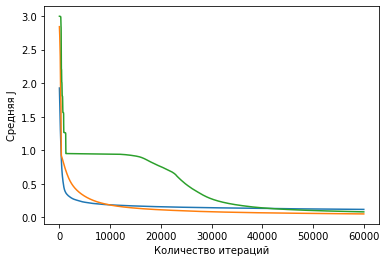

In [68]:
plt.plot(a2)
plt.plot(a3)
plt.plot(a4)
plt.ylabel('Средняя J')
plt.xlabel('Количество итераций')
plt.show()

In [69]:
a = MyNeuroNet([64, 50, 10],alpha = 0.25, iter_num = 10000)
a.train(X_train, y_train_vect, y_train)
t1 = a.avg_cost_func
print(3)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

a = MyNeuroNet([64, 40, 10],alpha = 0.25, iter_num = 10000)
a.train(X_train, y_train_vect, y_train)
t2 = a.avg_cost_func
print(3)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

a = MyNeuroNet([64, 30, 10],alpha = 0.25, iter_num = 10000)
a.train(X_train, y_train_vect, y_train)
t3 = a.avg_cost_func
print(3)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

a = MyNeuroNet([64, 20, 10],alpha = 0.25, iter_num = 10000)
a.train(X_train, y_train_vect, y_train)
t4 = a.avg_cost_func
print(3)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

a = MyNeuroNet([64, 15, 10],alpha = 0.25, iter_num = 10000)
a.train(X_train, y_train_vect, y_train)
t5 = a.avg_cost_func
print(3)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

3
95.55555555555556
97.4947807933194
3
95.27777777777777
97.7731384829506
3
96.94444444444444
98.12108559498957
3
96.11111111111111
97.7731384829506
3
97.22222222222221
97.84272790535839


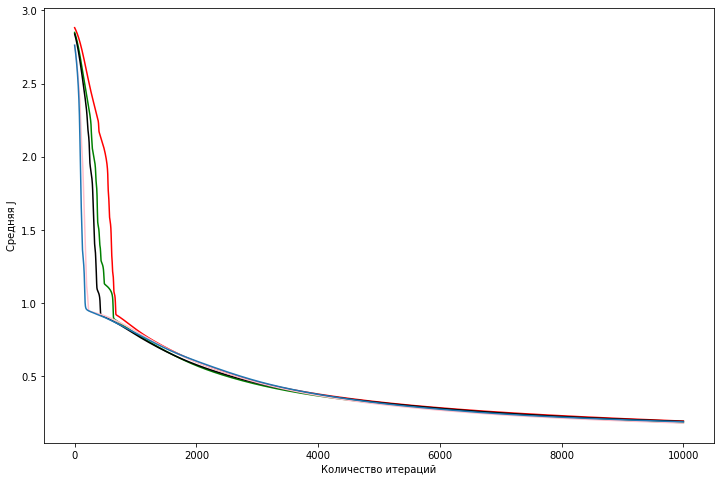

In [78]:
plt.figure(figsize=(12,8))
plt.plot(t1, 'r')
plt.plot(t2, 'g')
plt.plot(t3, 'black')
plt.plot(t4, 'pink')
plt.plot(t5)
plt.ylabel('Средняя J')
plt.xlabel('Количество итераций')
plt.show()

In [79]:
a = MyNeuroNet([64, 50, 20, 15, 10],alpha = 0.25, iter_num = 60000)
a.train(X_train, y_train_vect, y_train)
r1 = a.avg_cost_func
print(4)
print(accuracy_score(a.predict(X_test), y_test)*100)
print(accuracy_score(a.predict(X_train), y_train)*100)

4
7.5
10.647181628392484


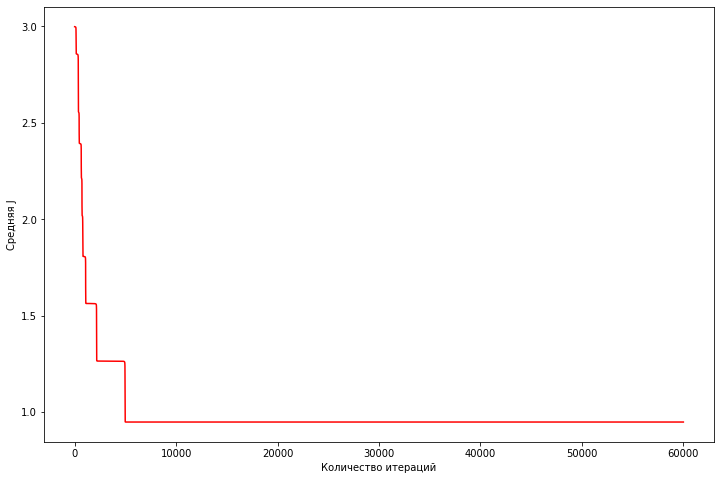

In [80]:
plt.figure(figsize=(12,8))
plt.plot(r1, 'r')
plt.ylabel('Средняя J')
plt.xlabel('Количество итераций')
plt.show()